# Demo RNA de Hopfield para procesar imágenes e identificar TIPOS de caracteres Chinos de Números
Funciones adaptadas de https://github.com/yosukekatada/Hopfield_network/blob/master/hopfield.py

1) Cargar librerías:

In [1]:
#@title Librerías a usar

import tensorflow as tf
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import os

from PIL import Image
from PIL import ImageDraw
import random
import copy

import ipywidgets as widgets
from ipywidgets import Box, Layout

print("Librerías cargadas")

Librerías cargadas


2) Montar el Drive:

In [6]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

# directorio local en Google Drive
path = '/content/gdrive/My Drive/IA/demoML/imagenes/NrosChinos' #@param {type:"string"}


Mounted at /content/gdrive


3) Cargar imágenes para entrenar el modelo:

Tamaño Imagen:  (100, 100, 1)

> Cargando imágenes de  /content/gdrive/My Drive/IA/demoML/imagenes/NrosChinos :

 Número  1


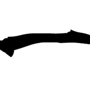


 Número  2


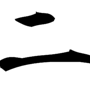


 Número  3


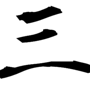


 Número  4


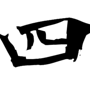


 Número  5


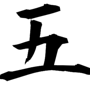


 Número  6


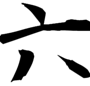


 Número  7


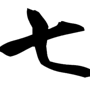


 Número  8


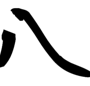


 Número  9


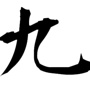


 Número 10


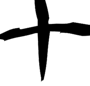



> Imágenes cargadas para Entrenamiento:  10


In [41]:
#@title Cargar las imágenes

imagen_ancho_alto =  100 #@param {type:"integer"}
imagen_ajustar_tamaño_x = 5 #@param {type:"integer"}
imagen_ajustar_tamaño_y =  7#@param {type:"integer"}

## aplicación de los parámetros elegidos
if imagen_ancho_alto<=10:
  imagen_ancho_alto = 10
IMAGE_SHAPE = (imagen_ancho_alto, imagen_ancho_alto, 1)
print ("Tamaño Imagen: ", IMAGE_SHAPE)
cropSizeX =  0
if imagen_ajustar_tamaño_x>=0:
  cropSizeX = imagen_ajustar_tamaño_x
cropSizeY =  0
if imagen_ajustar_tamaño_y>=0:
  cropSizeY = imagen_ajustar_tamaño_y


# carga las imágenes PIL en un vector
def cargarImagenes(imagPath, mostrarImg=False):
  print("\n> Cargando imágenes de ", imagPath, ":")
  imagFN = os.listdir( imagPath )
  imagFN.sort()
  arClases = []
  arImages = []
  for each_imagFN in imagFN:
    # cargar imagen
    imag = Image.open(imagPath + "/" + each_imagFN) 
    # ajusta tamaño y BN
    if IMAGE_SHAPE[2]==1:              
      tipoImage = 'L'
    else:                
      tipoImage = 'RGB'
    imag = imag.convert(tipoImage)    
    imag = imag.resize((IMAGE_SHAPE[0], IMAGE_SHAPE[1]))
    # raliza el crop si corresponde
    imag = imag.crop((cropSizeX, cropSizeY, IMAGE_SHAPE[0]-cropSizeX, IMAGE_SHAPE[1]-cropSizeY))
    clase = os.path.splitext(each_imagFN)[0]
    arClases.append( clase )
    arImages.append( imag )
    if mostrarImg:
      print("\n", clase)
      display( imag )
  return arImages, arClases


# carga las imágenes
images_original, clases_original = cargarImagenes(path, True )

print("\n\n> Imágenes cargadas para Entrenamiento: ", len(images_original))



In [42]:
#@title Seleccionar imágenes para entrenar

# combo selección de imágenes
selImagenes = widgets.SelectMultiple(
      options=list(clases_original),
      value=list([]),
      description='Seleccionar Imágenes:',
      rows=len(clases_original),
      layout=Layout(display="flex")
)

ui = widgets.HBox([selImagenes])

def determinaImgSeleccionadas(clasesImgs, estan=True):
  global images_original, clases_original
  selImgs = []
  selClases = []
  for img, cl in zip(images_original, clases_original):
    if (estan and (cl in clasesImgs)) or (not(estan) and (cl not in clasesImgs)):
      selImgs.append( img )
      selClases.append( cl )
  return selImgs, selClases


# función auxiliar para comparar vectores
def compararVectores(v1, v2):
  if (len(v1) != len(v2)):
    print("Error: los vectores tienen diferente tamaño!")
    return -1, -1
  ig = 0
  dif = 0
  for a, b in zip(v1, v2):
    if a == b:
      ig = ig + 1
    else:
      dif = dif + 1
  return ig, dif

# función auxiliar para comparar matrices
def compararMatrices(m1, m2):
  tamI = m1.shape[0]
  tamJ = m1.shape[1]
  if (tamI != m2.shape[0]) or (tamJ != m2.shape[1]):
    print("Error: las matrices tienen diferente tamaño!")
    return -1, -1
  ig = 0
  dif = 0
  for i in range(tamI):
    for j in range(tamJ):      
      if m1[i,j] == m2[i,j]:
        ig = ig + 1
      else:
        dif = dif + 1
  return ig, dif

# Convertir imagen a un vector
def readImg2array(pilIN, thresholdPix=150):
    imgArray = np.asarray(pilIN, dtype=np.uint8)
    x = np.ones(imgArray.shape, dtype=np.float)
    x[imgArray >= thresholdPix] = -1
    #x[imgArray < thresholdPix] = 1
    #x[x==0] = -1
    return x

# Converit un vectoa  una imagen
def array2img(data):
    #data is 1 or -1 matrix
    y = np.zeros(data.shape, dtype=np.uint8)
    y[data==1] = 0
    y[data==-1] = 255
    img = Image.fromarray(y, mode="L")
    return img

#convert matrix to a vector
def mat2vec(x):
    m = x.shape[0]*x.shape[1]
    tmp = np.zeros(m)
    c = 0
    for i in range(x.shape[0]):
      for j in range(x.shape[1]):
          tmp[c] = x[i,j]
          c +=1
    return tmp

# Controla ortogonalidad de las imágenes seleccionadas para entrenar
def controlarOrtogonalidad(imgsEntrenar, clasesEntrenar):
  if len(imgsEntrenar) == 0:
    print("No se seleccionaron imágenes para entrenar!")
  else:
    print("Controlando diferencias entre imágenes: ")    
    i = 0
    while i < len(imgsEntrenar):
      im1 = imgsEntrenar[i]
      cl1 = clasesEntrenar[i]
      j = i + 1
      # prepara la imagen 1
      x1 = readImg2array(im1)
      while j < len(imgsEntrenar):
        im2 = imgsEntrenar[j]
        cl2 = clasesEntrenar[j]
        # prepara la imagen 2
        x2 = readImg2array(im2)   
        # compara 
        cantIg, cantDist = compararMatrices(x1, x2)
        difPorc = (cantDist/(cantDist+cantIg))*100
        if difPorc > 50:
          vin = "+"
          orto = "es ORTOGONAL"
        else:
          vin = "-"
          orto = "NO es ORTOGONAL"
        print(vin, " comparación de", cl1, "y", cl2, ": ", cantIg, "pixeles iguales con ", round(difPorc, 2), "% de diferencia ->", orto)
        j = j + 1        
      i = i + 1        


# inicializar
matW = None
imgsEntrenar = None
clasesEntrenar = None

def cambiaSeleccion(selImgs):
  global matW, imgsEntrenar, clasesEntrenar
  # determina imágenes seleccionadas
  imgsEntrenar, clasesEntrenar = determinaImgSeleccionadas(list(selImgs), estan=True)
  # controla ortonalidad entre las imagenes
  if len(imgsEntrenar) > 1:
    controlarOrtogonalidad(imgsEntrenar, clasesEntrenar)

out = widgets.interactive_output(cambiaSeleccion, {'selImgs': selImagenes})
display(ui, out)



Output()

4) Establecer el modelo y entrenar la RNA:

In [48]:
#@title Establecer modelo y Entrenar 


# Calculos los pesos para una imagen
def calculaW(x):
    if len(x.shape) != 1:
        print("Error: no es un vector!")
        return None
    else:           
      # define la transpuesta y ajusta la forma del vector
      tx = np.matrix(x).T
      x = x.reshape((1,x.shape[0]))
      # multiplica la transpuesta por sigo misma
      w = np.dot(tx, np.array(x)) 
      # llena la diagonal con ceros
      for i in range(w.shape[0]):
          w[i,i] = 0
    return w

def create_W(x):
    if len(x.shape) != 1:
        print("Error: no es un vector!")
        return None
    else:
        w = np.zeros([len(x),len(x)])
        for i in range(len(x)):
            for j in range(i,len(x)):
                if i == j:
                    w[i,j] = 0
                else:
                    w[i,j] = x[i]*x[j]
                    w[j,i] = w[i,j]
    return w


# Entrena la red de Hopfield
def entrenar(arImages, arClases, mostrarDetalle=False):
  print("> Entrenamiento de la red: ")
  num_files = 0
  w = None
  for img, cl in zip(arImages, arClases):
      # prepara la imagen     
      x = readImg2array(img)
      x_vec = mat2vec(x)
      # calcula matriz de pesos de la imagen
      tmp_w = calculaW(x_vec)
      if mostrarDetalle:
        print("\n  W de ", cl, ":")
        print(tmp_w)
      # actualiza la matriz de pesos general
      if num_files == 0:
          w = tmp_w
          num_files = 1
      else:
          w = w + tmp_w
          num_files += 1
  print("\nEntrenamiento finalizado para ", w.shape[0]," neuronas.")
  if mostrarDetalle:
    print("\n  Matriz de Pesos General de forma ", w.shape, ":")
    print(w)
  return w 

if len(imgsEntrenar) > 0:
  # realiza el entrenamiento de la red de Hopfield 
  # con las imágenes cargadas y seleccionadas
  matW = entrenar(imgsEntrenar, clasesEntrenar, mostrarDetalle=True)
else:
  matW = None
  print("No se seleccionaron imágenes para entrenar!")


> Entrenamiento de la red: 

  W de  Número  1 :
[[0. 1. 1. ... 1. 1. 1.]
 [1. 0. 1. ... 1. 1. 1.]
 [1. 1. 0. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 0. 1. 1.]
 [1. 1. 1. ... 1. 0. 1.]
 [1. 1. 1. ... 1. 1. 0.]]

  W de  Número  4 :
[[0. 1. 1. ... 1. 1. 1.]
 [1. 0. 1. ... 1. 1. 1.]
 [1. 1. 0. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 0. 1. 1.]
 [1. 1. 1. ... 1. 0. 1.]
 [1. 1. 1. ... 1. 1. 0.]]

  W de  Número  5 :
[[0. 1. 1. ... 1. 1. 1.]
 [1. 0. 1. ... 1. 1. 1.]
 [1. 1. 0. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 0. 1. 1.]
 [1. 1. 1. ... 1. 0. 1.]
 [1. 1. 1. ... 1. 1. 0.]]

Entrenamiento finalizado para  7740  neuronas.

  Matriz de Pesos General de forma  (7740, 7740) :
[[0. 3. 3. ... 3. 3. 3.]
 [3. 0. 3. ... 3. 3. 3.]
 [3. 3. 0. ... 3. 3. 3.]
 ...
 [3. 3. 3. ... 0. 3. 3.]
 [3. 3. 3. ... 3. 0. 3.]
 [3. 3. 3. ... 3. 3. 0.]]


5) Evaluar el modelo de la RNA entrenado:


> Reconociendo imágenes: 


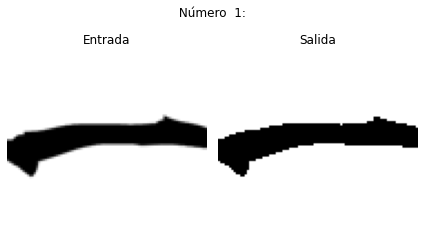

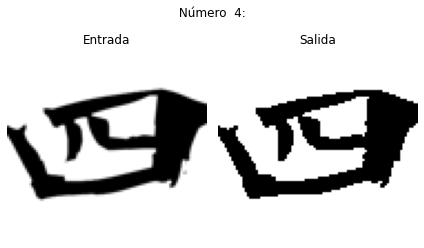

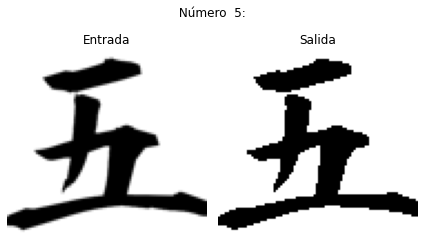

In [49]:
#@title Probar red entrenada con imágenes usadas en el entrenamiento
 
# procesa una imagen
def reconocer(w, vec, maxTime=1000):
    ant_vec = None
    for s in range(maxTime):
      # multiplica por la matriz de pesos      
      u = np.dot(vec, w)
      # aplica función 
      for i in range(len(vec)):
        if u[0,i] > 0:
            vec[i] = 1
        elif u[0,i] < 0:
            vec[i] = -1
      if ant_vec is not None:
        # analiza si es igual al anterior
        iguales = True
        for j in range(len(vec)):
          if vec[j] != ant_vec[j]:
            iguales = False
            break
        if iguales:
          # se encontraron iguales consecutivos, 
          # se estabiliza por lo que no debe seguir iterando
          break
      # guarda el último generado
      ant_vec = copy.deepcopy(vec)
    # devuelve el vector procesado
    return vec

def reconocerImagenes(arImages, arClases=None):
  print("\n> Reconociendo imágenes: ")
  for i in range(len(arImages)):    
    # prepara la imagen
    t = readImg2array(arImages[i])
    auxShape = t.shape
    t_vec = mat2vec(t)
    # procesa por la red
    t_vec_after = reconocer(w=matW, vec=t_vec)
    t_vec_after = t_vec_after.reshape(auxShape)
    # muestra los resultados
    if arClases is not None and i<len(arClases):
      strTitulo = " " + str(arClases[i]) + ": "
    else:
      strTitulo = ""
    fig = plt.figure()
    plt.gray()      
    fig.suptitle( strTitulo )
    # muestra la entrada
    ax1 = fig.add_subplot(121)
    ax1.title.set_text('Entrada')
    ax1.imshow( arImages[i] )
    plt.axis("off")  
    # muestra la salida
    ax2 = fig.add_subplot(122)
    ax2.title.set_text('Salida')
    ax2.imshow( array2img(t_vec_after) )
    plt.axis("off")  
    plt.tight_layout()
    fig = plt.gcf()

if matW is None:
  print("Error: la matriz de pesos W no se encuentra definida!")
else:
  if len(imgsEntrenar)==0:
    print("No hay imágenes para procesar!")
  else:  
    # procesar imágenes de entrenamiento
    reconocerImagenes(imgsEntrenar, clasesEntrenar)      



> Reconociendo imágenes: 


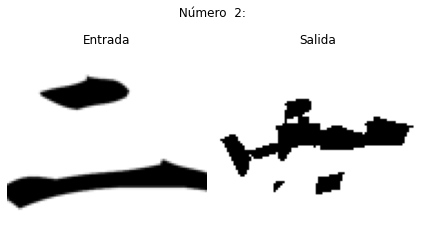

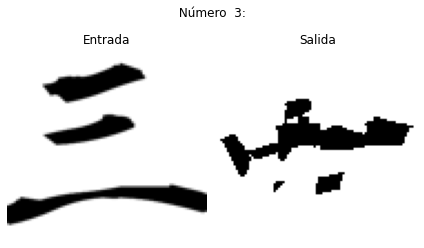

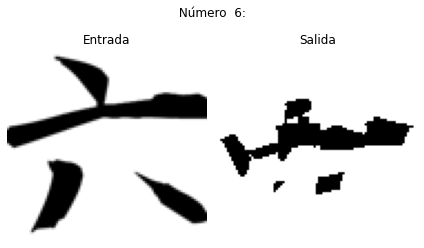

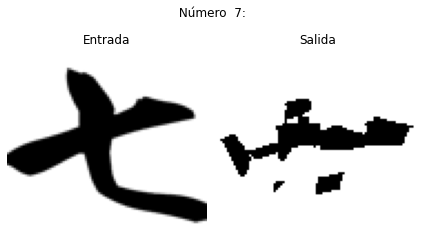

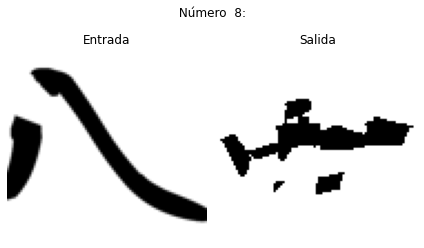

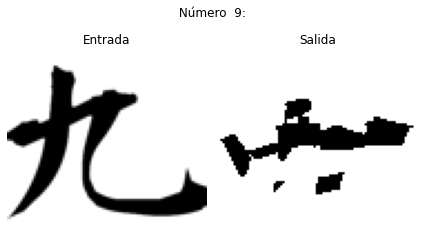

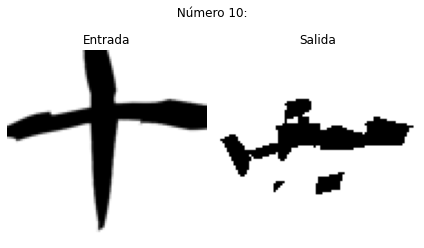

In [50]:
#@title Probar red entrenada con imágenes no usadas en el entrenamiento
 
if matW is None:
  print("Error: la matriz de pesos W no se encuentra definida!")
else:
  # procesar imágenes no de entrenamiento
  imgNoEntrenar,  clasesNoEntrenar = determinaImgSeleccionadas(clasesEntrenar, estan=False)
  if len(imgNoEntrenar)==0:
    print("No hay imágenes para procesar!")
  else:
    # procesar imágenes no usadas en el entrenamiento
    reconocerImagenes(imgNoEntrenar, clasesNoEntrenar)      



> Reconociendo imágenes: 


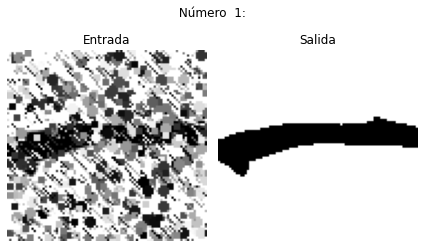

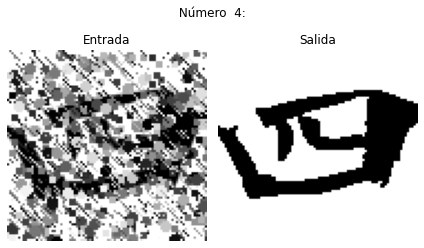

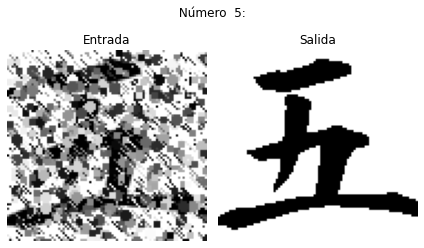

In [52]:
#@title Probar red entrenada con imágenes que se les agrega ruido

cantidad_ruido = 1500 #@param {type: "integer"} 
solo_imagenes_entrenadas = True #@param {type: "boolean"} 

# agrega ruido al azar en la imagen
def agregarRuido(imagen, cantidad=250):
    draw = ImageDraw.Draw(imagen)    
    for i in range(cantidad):
      # determina color, posicion y tamaño
      color = random.randint(0, 255)    
      posX = random.randint(0, imagen.size[0])
      posY = random.randint(0, imagen.size[1])
      tam =random.randint(1, imagen.size[1]//20)      
      # determina tipo de ruido
      tipo = random.randint(1, 3)
      # agrega 
      if tipo == 1:
        draw.point((posX, posY, posX, posY), fill=color)
      elif tipo == 2:
        draw.ellipse((posX, posY, posX + tam, posY + tam), fill=color)
      elif tipo == 3:
        draw.line((posX, posY, posX + tam, posY + tam), fill=color)
    return imagen 

if matW is None:
  print("Error: la matriz de pesos W no se encuentra definida!")
else:
  if len(imgsEntrenar)==0:
    print("No hay imágenes para procesar!")
  else:  
    # agrega ruido en las imagenes
    imgsRuido = []
    if solo_imagenes_entrenadas:
      # solo imágenes entrenadas
      clasesRuido = clasesEntrenar
      for im in imgsEntrenar:
        imgsRuido.append( agregarRuido( copy.deepcopy(im), cantidad_ruido ) )
    else:
      # todas las imágenes
      clasesRuido = clases_original
      for im in images_original:
        imgsRuido.append( agregarRuido( copy.deepcopy(im), cantidad_ruido ) )
    # procesar imágenes de entrenamiento
    reconocerImagenes(imgsRuido, clasesRuido)      
